### Extract Icesat2 data (This code is validate only after downloading HDF5 file)

In [4]:
from pathlib import Path
import glob

In [5]:
#You need to download data from https://nsidc.org/data/ATL06/versions/3
all_data=glob.glob('C:/Users/jsait/Icesat2_with_DEM/Data/*/*.h5')
files = list(all_data)

for f in files[:10]: print(f)
print('Total number of files:', len(files))

C:/Users/jsait/Icesat2_with_DEM/Data\177207966\ATL06_20181224093107_13250106_003_01.h5
C:/Users/jsait/Icesat2_with_DEM/Data\177208086\ATL06_20181228092248_13860106_003_01.h5
C:/Users/jsait/Icesat2_with_DEM/Data\177214592\ATL06_20181230204120_00370202_003_01.h5
C:/Users/jsait/Icesat2_with_DEM/Data\177214997\ATL06_20181029234603_04790103_003_01.h5
Total number of files: 4


In [3]:
!h5ls -r {files[0]} 

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

/gt3l/land_ice_segments/dem/dem_flag Dataset {2/Inf}
/gt3l/land_ice_segments/dem/dem_h Dataset {2/Inf}
/gt3l/land_ice_segments/dem/geoid_h Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics Group
/gt3l/land_ice_segments/fit_statistics/dh_fit_dx Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/dh_fit_dx_sigma Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/dh_fit_dy Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/h_expected_rms Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/h_mean Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/h_rms_misfit Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/h_robust_sprd Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/n_fit_photons Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/n_seg_pulses Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/sigma_h_mean Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/signal_selection_source Dataset {2/Inf}
/gt3l/land_ice_segments/fit_statistics/signal_

In [5]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """Converte GPS time to decimal years."""
    return Time(time, format='gps').decimalyear


def orbit_type(time, lat, tmax=1):
    """Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


In [6]:
import h5py
import numpy as np

def read_atl06(fname, outdir='data', bbox=None):
    """Read one ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k, g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
        
        data = {}
    
        try:
            # Load vars into memory (include as many as you want)
            with h5py.File(fname, 'r') as fi:
                
                data['lat'] = fi[g+'/land_ice_segments/latitude'][:]
                data['lon'] = fi[g+'/land_ice_segments/longitude'][:]
                data['h_li'] = fi[g+'/land_ice_segments/h_li'][:]
                data['s_li'] = fi[g+'/land_ice_segments/h_li_sigma'][:]
                data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:]
                data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
                data['s_fg'] = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
                data['snr'] = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
                data['h_rb'] = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
                data['dac'] = fi[g+'/land_ice_segments/geophysical/dac'][:]
                data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
                data['dh_fit_dx'] = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
                data['tide_earth'] = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
                data['tide_load'] = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
                data['tide_ocean'] = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
                data['tide_pole'] = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
                
                rgt = fi['/orbit_info/rgt'][:]                           # single value
                t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
                beam_type = fi[g].attrs["atlas_beam_type"].decode()      # strong/weak (str)
                spot_number = fi[g].attrs["atlas_spot_number"].decode()  # number (str)
                
        except:
            print('skeeping group:', g)
            print('in file:', fname)
            continue
            
        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (data['lon'] >= lonmin) & (data['lon'] <= lonmax) & \
                        (data['lat'] >= latmin) & (data['lat'] <= latmax)
        else:
            bbox_mask = np.ones_like(data['lat'], dtype=bool)  # get all
            
        # Only keep good data (quality flag + threshold + bbox)
        mask = (data['q_flag'] == 0) & (np.abs(data['h_li']) < 10e3) & (bbox_mask == 1)
        
        # If no data left, skeep
        if not any(mask): continue
        
        # Update data variables
        for k, v in data.items(): data[k] = v[mask]
            
        #----------------------------------------------------#
        # 3) Convert time, separate tracks, reproject coords #
        #----------------------------------------------------#
        
        # Time in GPS seconds (secs sinde Jan 5, 1980)
        t_gps = t_ref + data['t_dt']

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        is_asc = orbit_type(t_year, data['lat'])
        
        # Geodetic lon/lat -> Polar Stereo x/y
        x, y = transform_coord(4326, 32607, data['lon'], data['lat'])
      
        data['x'] = x
        data['y'] = y
        data['t_gps'] = t_gps
        data['t_year'] = t_year
        data['is_asc'] = is_asc
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output dir and file
        outdir = Path(outdir)    
        fname = Path(fname)
        outdir.mkdir(exist_ok=True)
        outfile = outdir / fname.name.replace('.h5', '_' + g[1:] + '.h5')
        
        # Save variables
        with h5py.File(outfile, 'w') as fo:
            for k, v in data.items(): fo[k] = v
            print('out ->', outfile)

In [8]:
outdir = Path.home()/'/home/junsaito/Icesat2_with_DEM/out/'

njobs = 8

bbox = None  #[-1124782, 81623, -919821, -96334]  # Kamb bounding box

outdir.mkdir(exist_ok=True)


if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, outdir, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, outdir, bbox) for f in files)


running in parallel (8 jobs) ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 328 out of 328 | elapsed:   25.4s finished


In [9]:
#outfiles = !ls {outdir}/*.h5
outfiles = list(outdir.glob('*.h5'))

for f in outfiles[:10]: print(f)
print('Total number of files:', len(outfiles))

/home/junsaito/Icesat2_with_DEM/out/ATL06_20191105060836_06010503_003_01_gt3r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20190930200827_00600505_003_01_gt3r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20200824155208_09210802_003_01_gt1r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20190803230141_05630406_003_01_gt3r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20181121105803_08220105_003_01_gt1r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20200726172436_04790803_003_01_gt3r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20190820220245_08220406_003_01_gt3r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20190128191730_04790202_003_01_gt1l.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20200824155208_09210802_003_01_gt2r.h5
/home/junsaito/Icesat2_with_DEM/out/ATL06_20200102031209_00980602_003_01_gt3r.h5
Total number of files: 1817


In [10]:
!h5ls -r {outfiles[0]}

/                        Group
/dac                     Dataset {28633}
/dh_fit_dx               Dataset {28633}
/f_sn                    Dataset {28633}
/h_li                    Dataset {28633}
/h_rb                    Dataset {28633}
/is_asc                  Dataset {28633}
/lat                     Dataset {28633}
/lon                     Dataset {28633}
/q_flag                  Dataset {28633}
/s_fg                    Dataset {28633}
/s_li                    Dataset {28633}
/snr                     Dataset {28633}
/t_dt                    Dataset {28633}
/t_gps                   Dataset {28633}
/t_year                  Dataset {28633}
/tide_earth              Dataset {28633}
/tide_load               Dataset {28633}
/tide_ocean              Dataset {28633}
/tide_pole               Dataset {28633}
/x                       Dataset {28633}
/y                       Dataset {28633}


Select the data from a wide vriety of parameters.

In [11]:
import h5py
import numpy as np
import dask.dataframe as dd

import warnings
warnings.filterwarnings("ignore")


def read_h5(fname, vnames=[]):
    """Read a list of vars [v1, v2, ..] -> 2D."""
    with h5py.File(fname, 'r') as f:
        return np.column_stack([f[v][()] for v in vnames])

    
# # Get list of files to plot
files = list(outdir.glob('*.h5'))

# # Variables we want to plot
# #vnames = ['lon', 'lat', 'h_elv']
vnames = ['x', 'y', 'h_li','t_year']

# # List with one dataframe per file
dfs = [dd.from_array(read_h5(f, vnames), columns=vnames) for f in files]

# # Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
print(df.head())

Number of files: 1817
Number of points: 19867608
               x             y         h_li       t_year
0  600774.648930  6.664623e+06  1424.051636  2019.844538
1  600769.047003  6.664662e+06  1414.080933  2019.844538
2  600253.588164  6.668532e+06  1086.452759  2019.844538
3  600246.022356  6.668591e+06  1086.079712  2019.844538
4  600243.498874  6.668611e+06  1086.019165  2019.844538


Save it as csv

In [10]:
df.to_csv(str(outdir)+'/points-*.csv')  # -> N csv files

['/home/junsaito/Icesat2_with_DEM/out/points-0000.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0001.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0002.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0003.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0004.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0005.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0006.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0007.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0008.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0009.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0010.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0011.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0012.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0013.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0014.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0015.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-0016.csv',
 '/home/junsaito/Icesat2_with_DEM/out/points-001

You can check what Icesat2 data looks like using the below code

In [ ]:
#%matplotlib widget
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib.cm import terrain as cmap

df = dd.read_csv(str(outdir)+'/*.csv')
pts = ds.Canvas(plot_width=800, plot_height=800)
#agg = pts.points(df, 'lon', 'lat', ds.mean('h_elv'))
agg = pts.points(df, 'x', 'y', ds.mean('h_li'))
img = tf.shade(agg, cmap=cmap, how='linear')
img


Make grid data from AarcticDEM. It is needed to extract value by Icesat2 data

In [136]:
# print out metadata information
#%matplotlib widget
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib.cm import terrain as cmap
import rasterio as rio
from affine import Affine
from pyproj import Proj, transform as transform
#file_in ='/home/junsaito/Icesat2_with_DEM/dem100m.tif'
file_in ='/home/junsaito/Icesat2_with_DEM/dem_icearea.tif'
#file_in ='/home/junsaito/Icesat2_with_DEM/dem_bedarea.tif' #if you want to check dh on icefree area
src = rio.open(file_in)
for k in src.meta:
  print(k,src.meta[k])

# Retrieve the affine transformation
if isinstance(src.transform, Affine):
     transform = src.transform
else:
     transform = src.affine

N = src.width
M = src.height
dx = transform.a
dy = transform.e
minx = transform.c
maxy = transform.f

# Read the image data, flip upside down if necessary
data_in = src.read(1)
if dy < 0:
  dy = -dy
  data_in = np.flip(data_in, 0)

print('Data minimum, maximum( = ', np.amin(data_in), np.amax(data_in))


driver GTiff
dtype float32
nodata -9999.0
width 593
height 528
count 1
crs EPSG:32607
transform | 95.79, 0.00, 648101.42|
| 0.00,-95.79, 6579521.88|
| 0.00, 0.00, 1.00|
Data minimum, maximum( =  nan nan


In [137]:
# Generate X and Y grid locations
xdata = minx + dx/2 + dx*np.arange(N)
ydata = maxy - dy/2 - dy*np.arange(M-1,-1,-1)

Multiple csv files merge into a csv file 

In [124]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
appended_data = []
for infile in glob.glob('/home/junsaito/Icesat2_with_DEM/out/*.csv', recursive=True):
    data = pd.read_csv(infile)
    # store DataFrame in list
    appended_data.append(data)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)
# write DataFrame to an excel sheet 
appended_data.to_csv('/home/junsaito/Icesat2_with_DEM/append/appended.csv')

Limitted the area you want adding the below code (You can also select the boundary using the five row code from the top)

In [126]:
glas_fn = '/home/junsaito/Icesat2_with_DEM/append/appended.csv'
glas_df = pd.read_csv(glas_fn)
glas_df['x'][glas_df['x']<=644817]=np.nan
glas_df['x'][glas_df['x']>=707250]=np.nan
glas_df['y'][glas_df['y']>=6582909]=np.nan
glas_df['y'][glas_df['y']<=6524780]=np.nan
#glas_df['t_year'][glas_df['t_year']>=2020]=np.nan
#glas_df['t_year'][glas_df['t_year']<=2019]=np.nan
glas_df= glas_df[glas_df['x'].notna()]
glas_df= glas_df[glas_df['y'].notna()]
#glas_df= glas_df[glas_df['t_year'].notna()]

glas_gdf = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df['x'],\
                                                   glas_df['y']), crs='EPSG:32607')

Check where icesat2 trak go onto ArcticDEM

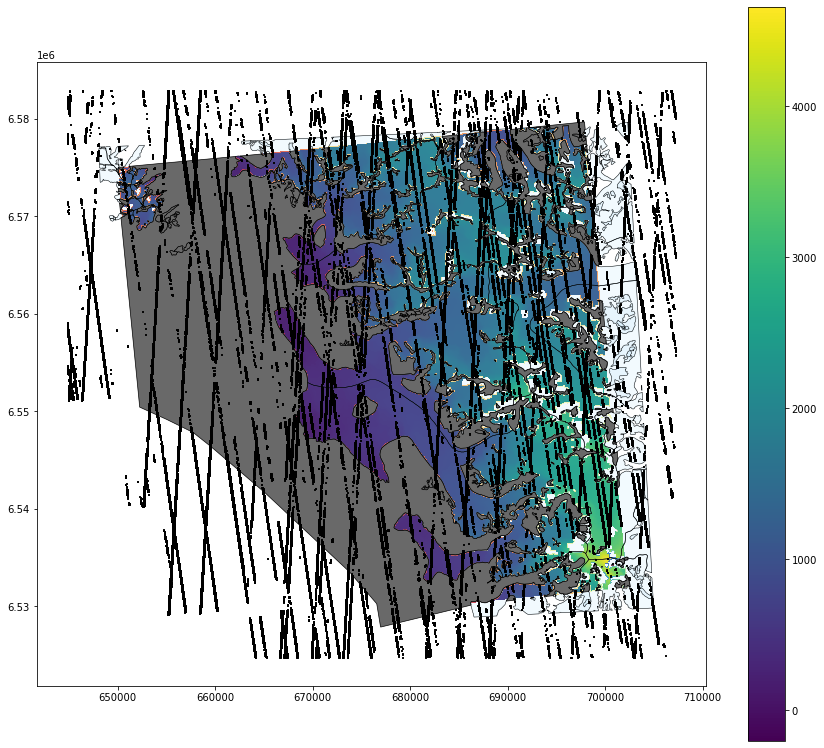

In [127]:
import rasterio as rio
from rasterio import plot
from affine import Affine
import matplotlib.pyplot as plt
file_in3 ='/home/junsaito/Icesat2_with_DEM/dem_icearea.tif'
src = rio.open(file_in3)
srtm_extent = rio.plot.plotting_extent(src)
srtm = src.read(1, masked=True)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(srtm, extent=srtm_extent)
x1=glas_df['x']
y1=glas_df['y']
ax.scatter(x1,y1,marker='s',s=1,facecolors='none',edgecolors='k',zorder=2)
cs=ax.imshow(srtm, extent=srtm_extent,cmap=plt.get_cmap('Spectral'), interpolation='nearest',
               vmin=-200, vmax=4700)
cs=ax.imshow(srtm, extent=srtm_extent)
cs=fig.colorbar(cs,ax=ax,shrink=0.9)

import shapefile 
sf=shapefile.Reader('/home/junsaito/Icesat2_with_DEM/polygon/icearea')
plt.figure
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end =len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x111 = [i[0] for i in shape.shape.points[i_start:i_end]]
        y111 = [i[1] for i in shape.shape.points[i_start:i_end]]
        plt.fill(x111,y111, color='lightskyblue',alpha=.1)
        plt.plot(x111,y111,color='k',lw=0.5)
#import ice free area
sf2=shapefile.Reader('/home/junsaito/Icesat2_with_DEM/polygon/icefree_utm7n')
plt.figure
for shape in sf2.shapeRecords():
    for ii in range(len(shape.shape.parts)):
        ii_start = shape.shape.parts[ii]
        if ii==len(shape.shape.parts)-1:
            ii_end =len(shape.shape.points)
        else:
            ii_end = shape.shape.parts[ii+1]
        x11111 = [ii[0] for ii in shape.shape.points[ii_start:ii_end]]
        y11111 = [ii[1] for ii in shape.shape.points[ii_start:ii_end]]
        
        plt.plot(x11111,y11111, color='k',lw=0.5)
        plt.fill(x11111,y11111, color='dimgrey',alpha=1)        
        
plt.show()  


Compare Icesat2 data with ArcticDEM

In [134]:
ex_ele=[]
for i in range(len(x1)):
    idy=(np.abs(ydata-np.array(y1)[i])).argmin()
    idx=(np.abs(xdata-np.array(x1)[i])).argmin()
    ele=data_in[idy,idx]
    ex_ele.append(ele)
z=glas_df['h_li']   
dif=z-ex_ele
df2 = pd.DataFrame({'Z': z[:],'Z1' : ex_ele[:],'Z_Z1':dif[:]})
df_concat = pd.concat([df2,glas_df], axis=1, sort=False)
print(df_concat)

                    Z      Z1          Z_Z1  Unnamed: 0  Unnamed: 0.1  \
112436    1941.574951 -9999.0  11940.574951         319           319   
112437    1948.334595 -9999.0  11947.334595         320           320   
112438    1956.178101 -9999.0  11955.178101         321           321   
112439    1962.677124 -9999.0  11961.677124         322           322   
112440    1961.576904 -9999.0  11960.576904         323           323   
...               ...     ...           ...         ...           ...   
19816520   610.981201 -9999.0  10609.981201         526           526   
19816521   614.340210 -9999.0  10613.340210         527           527   
19816522   617.263367 -9999.0  10616.263367         528           528   
19816523   619.800354 -9999.0  10618.800354         529           529   
19816524   622.159912 -9999.0  10621.159912         530           530   

                      x             y         h_li       t_year  \
112436    684628.434772  6.582905e+06  1941.574951  2019

Finally, Plot on the map 

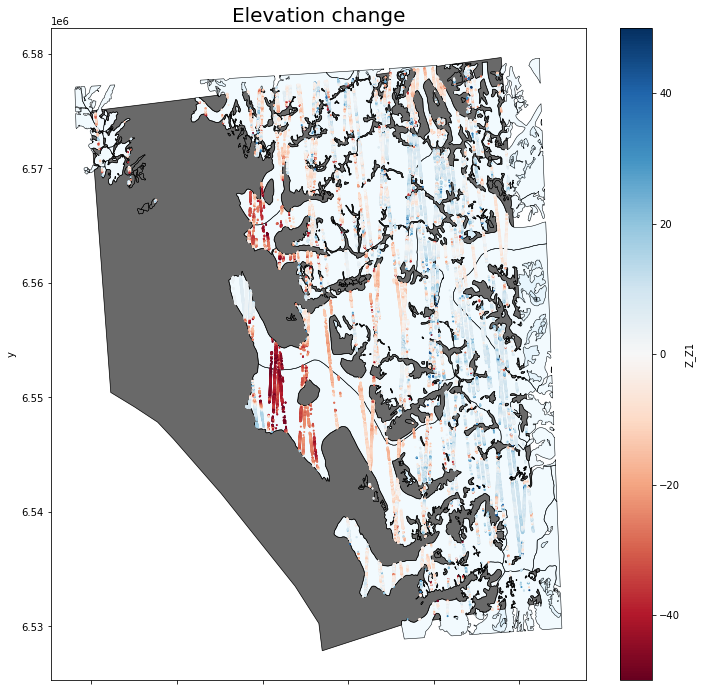

In [138]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (12, 12)
#fig, ax = plt.subplots(figsize=(15,15))
df_concat['Z_Z1'][df_concat['Z_Z1']>=50]=np.nan
df_concat['Z_Z1'][df_concat['Z_Z1']<=-50]=np.nan
ax =df_concat.plot(x='x', y='y', kind='scatter', c='Z_Z1', s=1, cmap='RdBu', vmin=-50, vmax=50,zorder=5)
ax.set_title('Elevation change',size=20)
import shapefile 
sf=shapefile.Reader('/home/junsaito/Icesat2_with_DEM/polygon/icearea')
plt.figure
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end =len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x111 = [i[0] for i in shape.shape.points[i_start:i_end]]
        y111 = [i[1] for i in shape.shape.points[i_start:i_end]]
        plt.fill(x111,y111, color='lightskyblue',alpha=.1)
        plt.plot(x111,y111,color='k',lw=0.5)
#import ice free area
sf2=shapefile.Reader('/home/junsaito/Icesat2_with_DEM/polygon/icefree_utm7n')
plt.figure
for shape in sf2.shapeRecords():
    for ii in range(len(shape.shape.parts)):
        ii_start = shape.shape.parts[ii]
        if ii==len(shape.shape.parts)-1:
            ii_end =len(shape.shape.points)
        else:
            ii_end = shape.shape.parts[ii+1]
        x11111 = [ii[0] for ii in shape.shape.points[ii_start:ii_end]]
        y11111 = [ii[1] for ii in shape.shape.points[ii_start:ii_end]]
        
        plt.plot(x11111,y11111, color='k',lw=0.5)
        plt.fill(x11111,y11111, color='dimgrey',alpha=1)        
    

plt.show()

Hist (elevation change)

0.690673828125


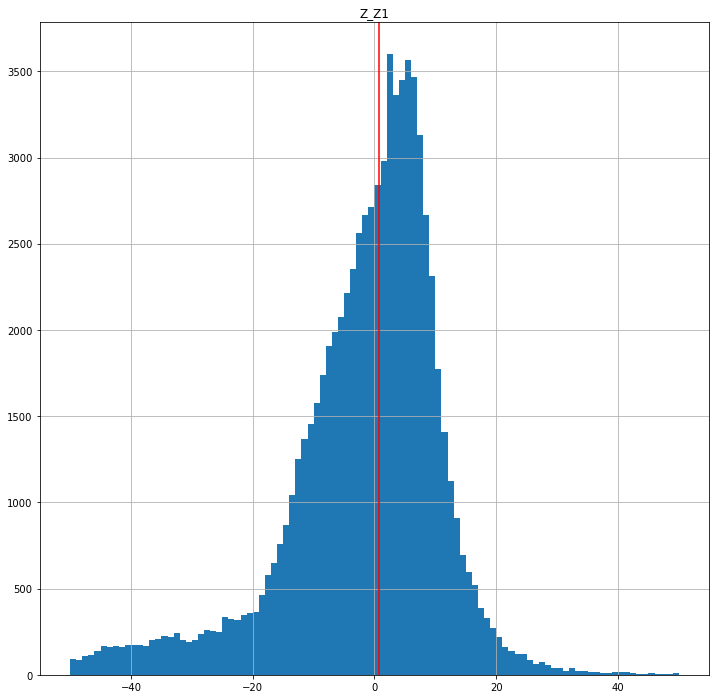

In [139]:
f, ax = plt.subplots()

#df_concat['Z_Z1'][df_concat['Z_Z1']>=50]=np.nan
#df_concat['Z_Z1'][df_concat['Z_Z1']<=-50]=np.nan
df_concat.hist('Z_Z1', ax=ax, bins=100, range=(-50,50));
#ax.axvline(0, color='k')
ax.axvline(df_concat['Z_Z1'].median(), color='r');
print(df_concat['Z_Z1'].median())

Scatter plot as well

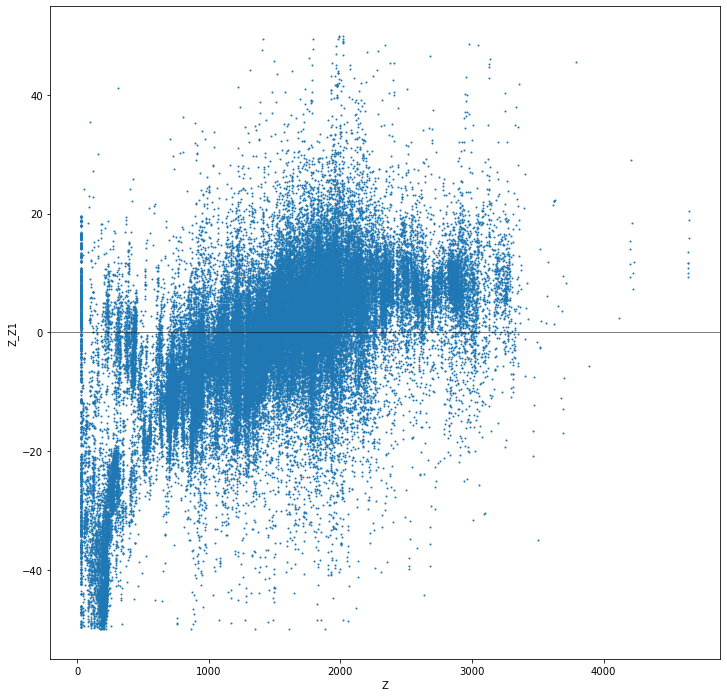

In [140]:
ax = df_concat.plot('Z', 'Z_Z1', kind='scatter', s=1)
#Add a horizontal line at 0
ax.axhline(0, color='k', lw=0.5);